# Comparing 18 BIKESTYLE-labels

1) How well do the features of a bicycle determine the label?
2) How well can machine learning detect the type of bicycle?

I do not know yet what exactly I will say / present

## Imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.tree import DecisionTreeClassifier     #Depth-8 Decision Tree
from sklearn.neighbors import KNeighborsClassifier  #K-Neighbors
from sklearn.ensemble import RandomForestClassifier #Random Forest


from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import set_config

In [2]:
#more imports
from sklearn.ensemble import AdaBoostClassifier        #AdaBoost
from sklearn.svm import SVC                            #Support Vector Clf.

from sklearn.gaussian_process import GaussianProcessClassifier     #Gaussian Pr. Clf.
from sklearn.neural_network import MLPClassifier                   #3-layer Neural Net, #6-Layer Neural Net
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV

In [3]:
#Read Data
data = pd.read_csv("Data/data_processed_cl.csv", index_col=0)
reduced = pd.read_csv("Data/BIKED_reduced.csv", index_col=0)

### Check Data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4511 entries, 0 to 4510
Columns: 1847 entries, SSSIDECX3 to SIZE_other
dtypes: float64(1415), int64(429), object(3)
memory usage: 63.6+ MB


There are 3 object columns (non-numeric). Let's check them out:

In [5]:
categorical_cols = data.select_dtypes(include="object").columns
print(len(list(categorical_cols)))
categorical_cols

3


Index(['BIKESTYLE', 'category', 'SIZE_in_text'], dtype='object')

Ah, 
* `BIKESTYLE` and  `category` are my label columns (one at a time) and 
* `SIZE_text` is for ordinal encoding

### INPUTS - Keep only two classes

In [6]:
restart = False # if set to true, then the results will be stored in a new dataframe. 
                # needs to be true when the notebook is restarting
                


## Splitting with label = `BIKESTYLE`

In [7]:
y_1 = data.pop("category")
y_2 = data.pop("BIKESTYLE")

In [8]:
X = data 

In [9]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_2, test_size=0.2, random_state=31416)

## Preprocessor Pipeline

In [10]:
# Select categorical and numerical columns
X_cat = X.select_dtypes(exclude="number").copy()
X_num = X.select_dtypes(include="number").copy()


In [11]:

# Numerical Pipeline, only with the SimpleImputer(strategy="mean") and MinMaxScaler
numeric_pipe = make_pipeline(
    SimpleImputer(strategy="constant"),   #strategy="constant"
    MinMaxScaler()
)


In [12]:
# Categorical Pipeline

# # # i. Defining the categorical encoder
ordinal_col_names = ['SIZE_text'] 

ordinal_cols = X_cat.columns.get_indexer(ordinal_col_names)
#onehot_cols = X_cat.columns.get_indexer(list(set(X_cat) - set(ordinal_col_names)))


# # # ii. Defining values for Ordinal Encoding
SIZE_text = ["0", "xs", "s", "m", "l", "xl", "xxl", "xxxl"]

ordinal_cats_list = [SIZE_text]

# # # iii. Defining the ColumnTransformer with 2 branches: ordinal & onehot (categorical encoder)
categorical_encoder = ColumnTransformer(
    transformers=[
        ("cat_ordinal", OrdinalEncoder(categories=ordinal_cats_list), ordinal_cols),
#        ("cat_onehot", OneHotEncoder(handle_unknown="ignore"), onehot_cols),
    ]
)

# # # iv. Categorical pipeline = "NA" imputer + categorical encoder
categoric_pipe = make_pipeline(SimpleImputer(strategy="constant", fill_value="NA"),
                                 categorical_encoder
                                )


In [13]:

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num_pipe", numeric_pipe, X_num.columns),
        ("cat_pipe", categoric_pipe, X_cat.columns),
    ]
)

## Preparing the models to be used

In [14]:
def get_model_and_params(model_name, param_grid):
    if model_name == "rforest":
        model = RandomForestClassifier(random_state=123)
        param_grid.update({"randomforestclassifier__warm_start": [True, False],
                "randomforestclassifier__n_estimators": [100, 200],
                "randomforestclassifier__max_depth": range(2, 14),
                "randomforestclassifier__min_samples_leaf": range(2, 10),
                "randomforestclassifier__criterion":["gini", "entropy"]})
    elif model_name == "knn":
        model = KNeighborsClassifier()
        param_grid.update({"kneighborsclassifier__n_neighbors": range(2, 50),
                "kneighborsclassifier__weights": ["uniform", "distance"]})
    elif model_name == "dt":
        model = DecisionTreeClassifier(random_state=123)
        param_grid.update({"decisiontreeclassifier__max_depth": range(2, 14),
                "decisiontreeclassifier__min_samples_leaf": range(2, 12),
#               "decisiontreeclassifier__min_samples_split": range(3, 40, 2),
                "decisiontreeclassifier__criterion":["gini", "entropy"]})
    elif model_name == "Ada":
        model = AdaBoostClassifier()
        param_grid.update({#"adaboostclassifiert__estimator": [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=3)],
                "adaboostclassifier__n_estimators": [50, 80],
                "adaboostclassifier__learning_rate": [0.5, 1.0, 1.5, 2.0, 2.5]})
    #elif model_name == "SVC": # runtime too long. Stopped after 2 hours 
    #    model = SVC()
    #    param_grid.update({"svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    #            "svc__class_weight": ["balanced", "None"]})
    elif model_name == "GaussPrC":
        model = GaussianProcessClassifier(1.0 * RBF(1.0))
        param_grid.update({"gaussianprocessclassifier__multi_class": ["one_vs_rest", "one_vs_one"]})
    elif model_name == "mlp":
        model = MLPClassifier()
        param_grid.update({"mlpclassifier__hidden_layer_sizes": [(200), (200, 200)],
            "mlpclassifier__max_iter": [3000, 5000]})

    return model, param_grid


## Build evaluation function for several models

In [101]:
def evaluate_models(list_of_models, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": []
    }
    param_grid = {}
    
    for i in list_of_models:
        #reset values to be empty : 
        model = ""
        param_grid.clear()
        param_grid = param_grid_preproc

        # # # # it would nice if I make this into a function get_model_and_params
        model, param_grid = get_model_and_params(i, param_grid)

        #create the full_pipeline
        full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

        # define cross validation
        search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=10,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5,
                      random_state=12
                    )                             

        # fit
        search.fit(X_train, y_train)
        print(search.best_params_)

        score_new["model"].append(i)

        ### testing accuracy
        y_test_pred = search.predict(X_test)
        acc_test = accuracy_score(y_test, y_test_pred)
        score_new["test_acc_score"].append(acc_test)

        #get score of TRAIN-Data (overfitting?)
        y_train_pred = search.predict(X_train)
        acc_train = accuracy_score(y_train, y_train_pred)
        score_new["train_acc_score"].append(acc_train)

        # keep scores of model (optional)
        score_new["best_score_of_CV"].append(search.best_score_)
        score_new["best_params"].append(search.best_params_)

        # confusion matrix
        conf = confusion_matrix(y_test, y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                                    display_labels=search.classes_)
        disp.plot()
        plt.show()

        #how do I use set_palette()
        #change plt.show() to sns.show()
        #How to set the palette to have the colors of my presentation?

        print(i, model)
        print(pd.DataFrame(conf))
        print("end")
    return pd.DataFrame(score_new)



## Running the pipeline for several models

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


{'randomforestclassifier__warm_start': True, 'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 12, 'randomforestclassifier__criterion': 'gini'}


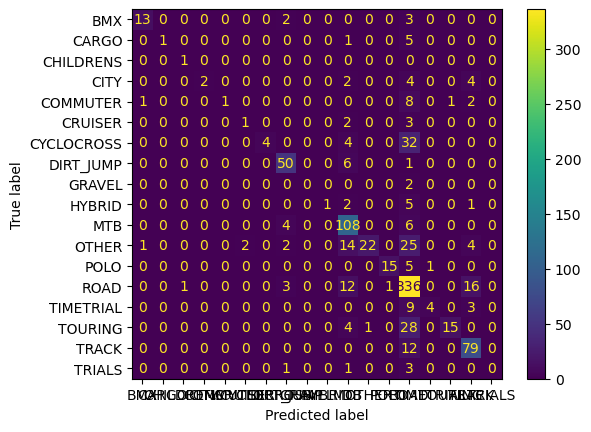

rforest RandomForestClassifier(random_state=123)
    0   1   2   3   4   5   6   7   8   9    10  11  12   13  14  15  16  17
0   13   0   0   0   0   0   0   2   0   0    0   0   0    3   0   0   0   0
1    0   1   0   0   0   0   0   0   0   0    1   0   0    5   0   0   0   0
2    0   0   1   0   0   0   0   0   0   0    0   0   0    0   0   0   0   0
3    0   0   0   2   0   0   0   0   0   0    2   0   0    4   0   0   4   0
4    1   0   0   0   1   0   0   0   0   0    0   0   0    8   0   1   2   0
5    0   0   0   0   0   1   0   0   0   0    2   0   0    3   0   0   0   0
6    0   0   0   0   0   0   4   0   0   0    4   0   0   32   0   0   0   0
7    0   0   0   0   0   0   0  50   0   0    6   0   0    1   0   0   0   0
8    0   0   0   0   0   0   0   0   0   0    0   0   0    2   0   0   0   0
9    0   0   0   0   0   0   0   0   0   1    2   0   0    5   0   0   1   0
10   0   0   0   0   0   0   0   4   0   0  108   0   0    6   0   0   0   0
11   1   0   0   0   0   2 

/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


{'kneighborsclassifier__weights': 'distance', 'kneighborsclassifier__n_neighbors': 4}


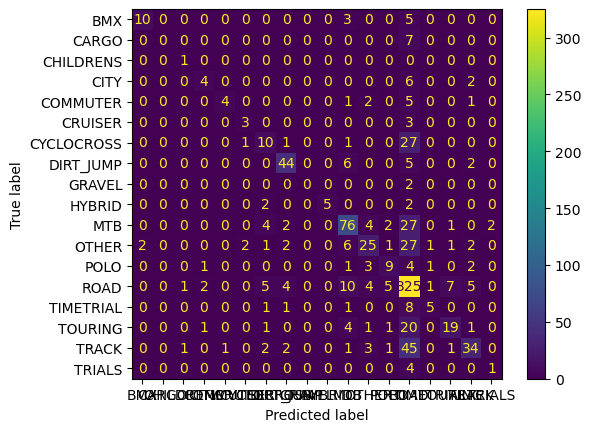

knn KNeighborsClassifier()
    0   1   2   3   4   5   6   7   8   9   10  11  12   13  14  15  16  17
0   10   0   0   0   0   0   0   0   0   0   3   0   0    5   0   0   0   0
1    0   0   0   0   0   0   0   0   0   0   0   0   0    7   0   0   0   0
2    0   0   1   0   0   0   0   0   0   0   0   0   0    0   0   0   0   0
3    0   0   0   4   0   0   0   0   0   0   0   0   0    6   0   0   2   0
4    0   0   0   0   4   0   0   0   0   0   1   2   0    5   0   0   1   0
5    0   0   0   0   0   3   0   0   0   0   0   0   0    3   0   0   0   0
6    0   0   0   0   0   1  10   1   0   0   1   0   0   27   0   0   0   0
7    0   0   0   0   0   0   0  44   0   0   6   0   0    5   0   0   2   0
8    0   0   0   0   0   0   0   0   0   0   0   0   0    2   0   0   0   0
9    0   0   0   0   0   0   2   0   0   5   0   0   0    2   0   0   0   0
10   0   0   0   0   0   0   4   2   0   0  76   4   2   27   0   1   0   2
11   2   0   0   0   0   2   1   2   0   0   6  25   1   27  

/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


{'decisiontreeclassifier__min_samples_leaf': 4, 'decisiontreeclassifier__max_depth': 8, 'decisiontreeclassifier__criterion': 'gini'}


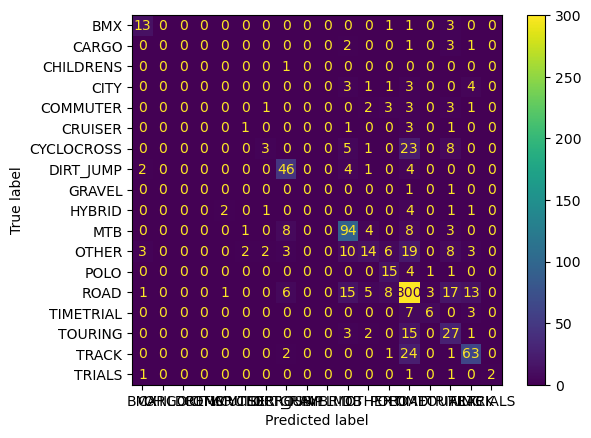

dt DecisionTreeClassifier(random_state=123)
    0   1   2   3   4   5   6   7   8   9   10  11  12   13  14  15  16  17
0   13   0   0   0   0   0   0   0   0   0   0   0   1    1   0   3   0   0
1    0   0   0   0   0   0   0   0   0   0   2   0   0    1   0   3   1   0
2    0   0   0   0   0   0   0   1   0   0   0   0   0    0   0   0   0   0
3    0   0   0   0   0   0   0   0   0   0   3   1   1    3   0   0   4   0
4    0   0   0   0   0   0   1   0   0   0   0   2   3    3   0   3   1   0
5    0   0   0   0   0   1   0   0   0   0   1   0   0    3   0   1   0   0
6    0   0   0   0   0   0   3   0   0   0   5   1   0   23   0   8   0   0
7    2   0   0   0   0   0   0  46   0   0   4   1   0    4   0   0   0   0
8    0   0   0   0   0   0   0   0   0   0   0   0   0    1   0   1   0   0
9    0   0   0   0   2   0   1   0   0   0   0   0   0    4   0   1   1   0
10   0   0   0   0   0   1   0   8   0   0  94   4   0    8   0   3   0   0
11   3   0   0   0   0   2   2   3   0   0  

In [16]:
# set models, pass param_grid for preprocessor-pipeline
list_of_models = ["rforest", "knn", "dt"] # , , "knn", "dt", "mlp", "rforest", "knn", "dt", "GaussPrC", "mlp" "SVC" "Ada", , "mlp"

param_grid_preproc = {}

score_new = evaluate_models(list_of_models, param_grid_preproc)

## Keep the scores

In [17]:
#Set to Initialize = True when you want to start over.
initialize_all_scores = restart

if initialize_all_scores == True:
    score_all = {
        "model": [], 
        "test_acc_score" : [],
        "train_acc_score" : [],
        "best_params": [],
        "best_score_of_CV": [],
        "dataset": [],
        "preprocessing": [],
    }
    score_all = pd.DataFrame(score_all)

In [18]:
#description of the current round
#score_all = pd.DataFrame([]) --> only once!
dataset = "18Cols,processed_cl" #"reduced,18labels"   #"reduced,19labels"
preprocessing = "split_0.8_vs_0.2,random_state=123,numerical_and_ordinalencoding,SimpleImputer,StandardScaler" #"only_numeric_cols,SimpleImputer_Mean"  #"all_columns,SimpleImputer_Mean,OneHot"

score_new["dataset"] = dataset
score_new["preprocessing"] = preprocessing

In [19]:
score_all = pd.concat([score_all, score_new], ignore_index=True)
score_all

,model,test_acc_score,train_acc_score,best_params,best_score_of_CV,dataset,preprocessing
0,rforest,0.723145,0.868902,"{'randomforestclassifier__warm_start': True, '...",0.732535,"18Cols,processed_cl","split_0.8_vs_0.2,random_state=123,numerical_an..."
1,knn,0.636766,1.000000,"{'kneighborsclassifier__weights': 'distance', ...",0.628876,"18Cols,processed_cl","split_0.8_vs_0.2,random_state=123,numerical_an..."
2,dt,0.646733,0.756652,{'decisiontreeclassifier__min_samples_leaf': 4...,0.666574,"18Cols,processed_cl","split_0.8_vs_0.2,random_state=123,numerical_an..."


**CONCLUSION**

**Accuracy for ROAD vs TRACK**

with a 0.8/0.2 split
* 95% accuray with random forest

**Accuracy for all 18 classes**

With a 0.66/0.33 split = 3000 /4500 split:
* 69% accurace with my RandomForest model / cleaned dataset
* 67% accuracy with the author's RandomForest model

With a 0.8/0.2 split
* 75% accuracy of RandomForest 

## Explore a single model and get feature names out

In [72]:
import seaborn as sns

def evaluate_model(model_name, param_grid_preproc):
    score_new = {
        "model": [],
        "test_acc_score": [],
        "train_acc_score": [],
        "best_score_of_CV": [],
        "best_params": []
    }
    param_grid = {}
    

    #reset values to be empty : 
    param_grid = param_grid_preproc

    # # # # it would nice if I make this into a function get_model_and_params
    model, param_grid = get_model_and_params(model_name, param_grid)

    #create the full_pipeline
    full_pipe = make_pipeline(preprocessor, 
                          StandardScaler(with_mean=False),
                          model
                             )

    # define cross validation
    search = RandomizedSearchCV(full_pipe,
                      param_grid,
                      cv=10,
                      verbose=1,
                      scoring="accuracy",
                      n_jobs=-2, 
                      n_iter=5,
                      random_state=12
                    )                             

    # fit
    search.fit(X_train, y_train)

    score_new["model"].append(model_name)

    ### testing accuracy
    y_test_pred = search.predict(X_test)
    acc_test = accuracy_score(y_test, y_test_pred)
    score_new["test_acc_score"].append(acc_test)

    #get score of TRAIN-Data (overfitting?)
    y_train_pred = search.predict(X_train)
    acc_train = accuracy_score(y_train, y_train_pred)
    score_new["train_acc_score"].append(acc_train)

    # keep scores of model (optional)
    score_new["best_score_of_CV"].append(search.best_score_)
    score_new["best_params"].append(search.best_params_)

    # confusion matrix
    conf = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(
        conf/np.sum(conf), annot=True, fmt='.1%', 
        cmap='Blues')


    #disp = ConfusionMatrixDisplay(confusion_matrix=conf,
    #                                display_labels=search.classes_)
    #disp.plot()
    #plt.show()

        #how do I use set_palette()
        #change plt.show() to sns.show()
        #How to set the palette to have the colors of my presentation?

    print(pd.DataFrame(conf))
    print("end")
    return pd.DataFrame(score_new), search

#### Set parameters (model_name) and build the model

In [73]:
# Call the function, evaluate one model, and get the object "search"
#model_name = "dt"           # Decision Tree
model_name = "rforest"     # Random Forest

model, param_grid = get_model_and_params(model_name=model_name, param_grid={})
model_classifier_name = type(model).__name__.lower()
model_classifier_name

'randomforestclassifier'

Fitting 10 folds for each of 5 candidates, totalling 50 fits


/Users/liane/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(


    0   1   2   3   4   5   6   7   8   9    10  11  12   13  14  15  16  17
0   13   0   0   0   0   0   0   1   0   0    0   0   0    4   0   0   0   0
1    0   1   0   0   0   0   0   0   0   0    1   0   0    5   0   0   0   0
2    0   0   1   0   0   0   0   0   0   0    0   0   0    0   0   0   0   0
3    0   0   0   2   0   0   0   0   0   0    2   0   0    4   0   0   4   0
4    0   0   0   0   1   0   0   0   0   0    0   0   2    8   0   1   1   0
5    0   0   0   0   0   1   0   0   0   0    2   0   0    3   0   0   0   0
6    0   0   0   0   0   0   3   0   0   0    3   0   0   34   0   0   0   0
7    0   0   0   0   0   0   0  50   0   0    6   0   0    1   0   0   0   0
8    0   0   0   0   0   0   0   0   0   0    0   0   0    2   0   0   0   0
9    0   0   0   0   0   0   0   0   0   1    3   0   0    4   0   0   1   0
10   0   0   0   0   0   0   0   4   0   0  109   0   0    5   0   0   0   0
11   1   0   0   0   0   2   0   2   0   0   14  20   0   27   0   0   4   0

,model,test_acc_score,train_acc_score,best_score_of_CV,best_params
0,rforest,0.713178,0.856707,0.725328,"{'randomforestclassifier__warm_start': True, '..."


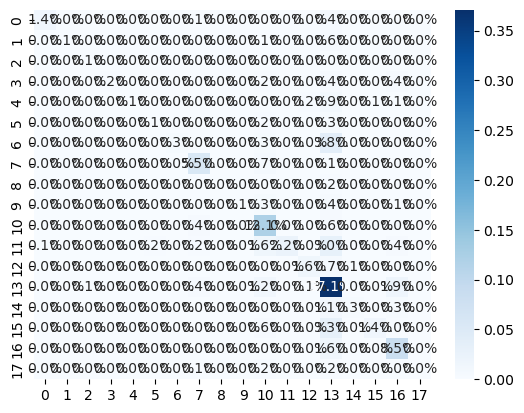

In [74]:
# fit and predict for one model
score_single_model, search = evaluate_model(model_name = model_name, param_grid_preproc= {})
score_single_model

### Let's save the column names

In [86]:
# save feature names for later use
feature_names = np.array(X.columns)
feature_names


array(['SSSIDECX3', 'SSSIDECX2', 'SSSIDECX1', ..., 'SIZE_in_inch',
       'SIZE_in_text', 'SIZE_other'], dtype=object)

In [87]:
print(len(feature_names)) # length 1 --> we need to transpose it!
feature_names = feature_names.reshape(-1, 1)  
feature_names

1845


array([['SSSIDECX3'],
       ['SSSIDECX2'],
       ['SSSIDECX1'],
       ...,
       ['SIZE_in_inch'],
       ['SIZE_in_text'],
       ['SIZE_other']], dtype=object)

In [88]:
# there are brakets in brakets, we need to flatten it
feature_names = feature_names.flatten()
print(len(feature_names), feature_names)
# --> now it looks good!

1845 ['SSSIDECX3' 'SSSIDECX2' 'SSSIDECX1' ... 'SIZE_in_inch' 'SIZE_in_text'
 'SIZE_other']


### Now we need to access the model

In [89]:
# access the DT model in the pipe
#  --> Does not work here, because I do not have the pipe-object
# which position?
# full_pipe.steps[2]

In [90]:
# access the model via the search
model = search.best_estimator_.named_steps[model_classifier_name]
importances = model.feature_importances_
importances

array([1.75121299e-03, 1.31955640e-03, 1.47539787e-03, ...,
       2.80079887e-04, 8.78999312e-05, 3.05013848e-04])

In [91]:
#both need to be the same length --> YES!
print(len(importances), len(feature_names)) 

1845 1845


In [92]:
features_df = {
    "columns": feature_names,
    "importance": importances}

features_df = pd.DataFrame(features_df)

In [93]:
features_df = features_df.sort_values("importance", ascending = False).head(10)
features_df


,columns,importance
1040,Teeth on chainring 0,0.024579
234,Seat tube length,0.020287
768,CS textfield,0.019868
1207,FDBSD,0.018944
1206,RDBSD,0.017191
1205,FDERD,0.014434
395,Number of cogs,0.014374
1067,Wheel width front,0.014153
1576,Fork type OHCLASS: 1,0.014140
1784,Handlebar style OHCLASS: 0,0.013757


In [97]:
#check how many features have been seen during fit:
number_of_features_seen_during_fit = model.n_features_in_
number_of_features_seen_during_fit # --> all

1845

In [98]:
X_train["CS textfield"].value_counts()

405.00     630
425.00     218
400.00     182
410.00     160
430.00     152
          ... 
403.16       1
1150.00      1
388.20       1
760.00       1
425.29       1
Name: CS textfield, Length: 582, dtype: int64

## Store results of all 18 labels

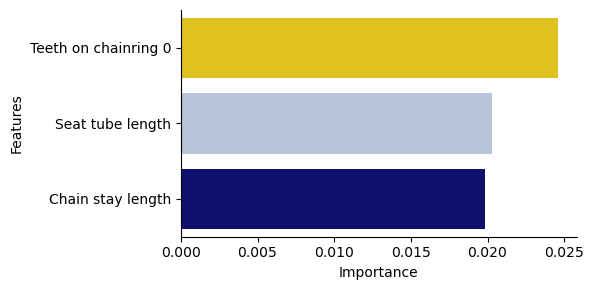

In [100]:

# store
pd.DataFrame(features_df).to_csv("All_labels.csv")

# graph
features_df.columns = ["Features", "Importance"]
features_df.iloc[2,0] = "Chain stay length"
#features_df.iloc[3,0] = "Dropout spacing style 3"
with sns.color_palette(["gold", "lightsteelblue", "navy"], as_cmap=False):
        sns.catplot(data=features_df.head(3), 
            kind="bar",
            x="Importance", 
            y="Features",
            height = 3,
            aspect = 2,
            estimator = sum
            );
    

## Store results of `Road` vs `Track`

In [32]:
import seaborn as sns

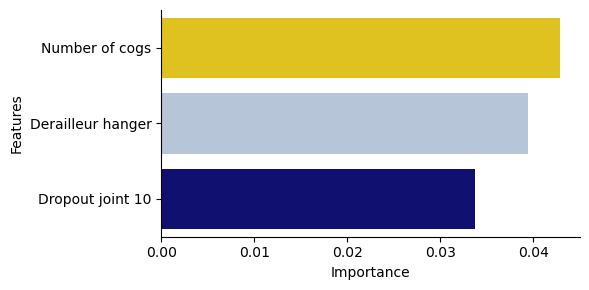

In [183]:
if road_vs_track == True:
    features_road_vs_track = features_df
    pd.DataFrame(features_road_vs_track).to_csv("Two_labels_Road_Track.csv")
    features_df.columns = ["Features", "Importance"]
    features_df.iloc[1,0] = "Derailleur hanger"
    features_df.iloc[3,0] = "Dropout spacing style 3"
    with sns.color_palette(["gold", "lightsteelblue", "navy"], as_cmap=False):
        sns.catplot(data=features_df.head(3), 
            kind="bar",
            x="Importance", 
            y="Features",
            height = 3,
            aspect = 2,
            estimator = sum
            );
    

In [81]:
#------------------------------ 2 Classes Road and Track ------------------------- 
#	columns	                                importance
#395	Number of cogs	                    0.042866
#1037	DERAILLEUR_HANGER	                0.039405
#20	    Dropout joint 10	                0.033720
#1419	Dropout spacing style OHCLASS: 3	0.029732
#561	Dropout joint 9	                    0.029418
#1072	Head angle	                        0.023782
#768	CS textfield	                    0.022753
#250	Dropout spacing	                    0.022565
#34	    Dropout joint 26	                0.019604
#37	    Dropout joint 23	                0.019048



#------------------------------ ALL 18 CLASSES ! -----------------------------------------------
# RESULTS FOR RANDOM FOREST
#   	columns	                    importance
#1040	Teeth on chainring 0	    0.028703        Number of teeth on chainring 0 (same as DT = #1)
#1206	RDBSD	                    0.021942        ...                         (also in DT #8 , here #2)
#1784	Handlebar style OHCLASS: 0	0.020609        ...                         (also in DT #10, here #3)
#768	CS textfield	            0.020594        ... some                    (also in DT #7 , here #4)
#1207	FDBSD	                    0.020481        ... more
#1205	FDERD	                    0.019444        ... columns
#1785	Handlebar style OHCLASS: 1	0.017893        ... in between
#1576	Fork type OHCLASS: 1	    0.017483        ...                         (also in DT #4 , here #8)
#250	Dropout spacing	            0.016615        ...
#1037	DERAILLEUR_HANGER	        0.016552        Schaltaufhängung -          (also in DT #2 , here #10) same importance!


#RESULTS FOR DECISION TREE
#   	columns	                    importance
#1040	Teeth on chainring 0	    0.236933        Number of teeth on chainring 0 (Anzahl Zähle auf Kettenblatt 0)
#1037	DERAILLEUR_HANGER	        0.169137        Schaltaufhängung - The hanger which fixes the gear shift to the frame at the rear wheel
#1128	Saddle height	            0.095040        
#1576	Fork type OHCLASS: 1	    0.079594        
#1205	FDERD	                    0.056719
#465	Wheel diameter front	    0.050802
#768	CS textfield	            0.041495
#1206	RDBSD	                    0.035787
#532	FORK0R	                    0.031524
#1784	Handlebar style OHCLASS: 0	0.026295

In [96]:
X_train.loc[:,X_train.columns.str.lower().str.contains("teeth on chainring")]

,Teeth on chainring 2,Teeth on chainring 0,Teeth on chainring 1
1845,24,53,39
3510,22,53,39
1302,24,53,39
370,24,48,36
1338,24,53,39
...,...,...,...
2679,24,53,39
3915,24,53,39
2300,24,36,39
1449,22,54,42
